In [1]:
import numpy as np
import matplotlib.pyplot as plt

from observationModel import *
from unscentedKalmanFilter import *
from helperFunctions import *

## Task 1: Obsevation Model
To properly implement a nonlinear Kalman filter, an observation model must be formulated that maps the raw 2D image features to a drone position and rotation. The steps taken to accompish this are summarized as:
1) Map the april tag IDs and corner numbers to a 3D position in the world frame.
2) Use solvePnP with the 2D image locations and corresponding 3D positions to obtain a position and roation of the world origin in the camera frame.
3) Perform appropriate rigid body transformations to obtain the drone/IMU position in the world frame, from the world origin position in the camera frame.

These steps are implemented in `estimate_pose(data)`, which takes in a datapoint and returns wether or not it was a success, the euler angles, and translation vector.

An example function call is provided below:

In [2]:
dataFull0 = scipy.io.loadmat('data/studentdata0.mat', simplify_cells=True) # Load in dataset 0
data = dataFull0['data'][100] # Select datapoint at time step 100
success, rvec, tvec = estimate_pose(data) # Call estimate_pose()
print(f"rvec (rad): {rvec}, tvec (m): {tvec}") # Display results

rvec (rad): [0.02595768 0.07467734 0.02489738], tvec (m): [0.76412785 1.1710384  0.84856448]


## Task 2: Visualization

Looping over the provided datasets, we can compare the 'truth' data with the observations calculated from this observation model.

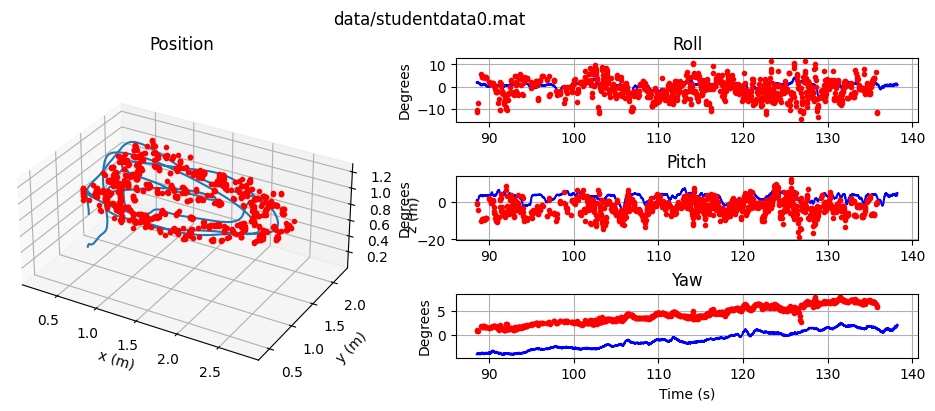

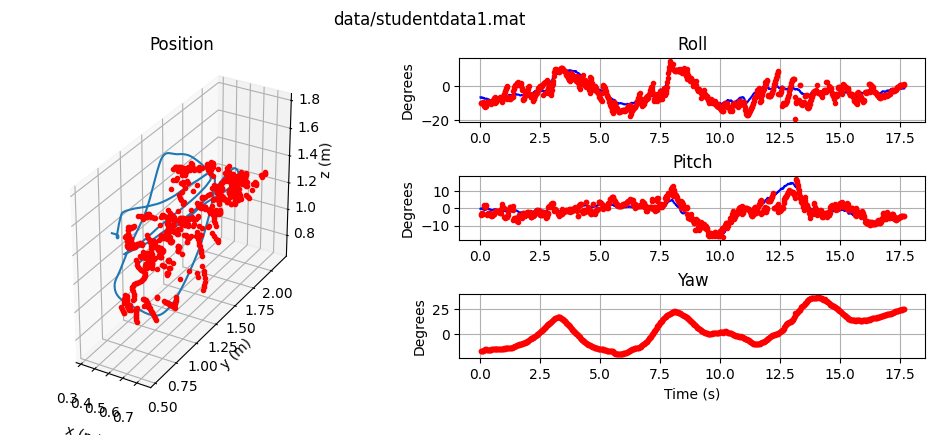

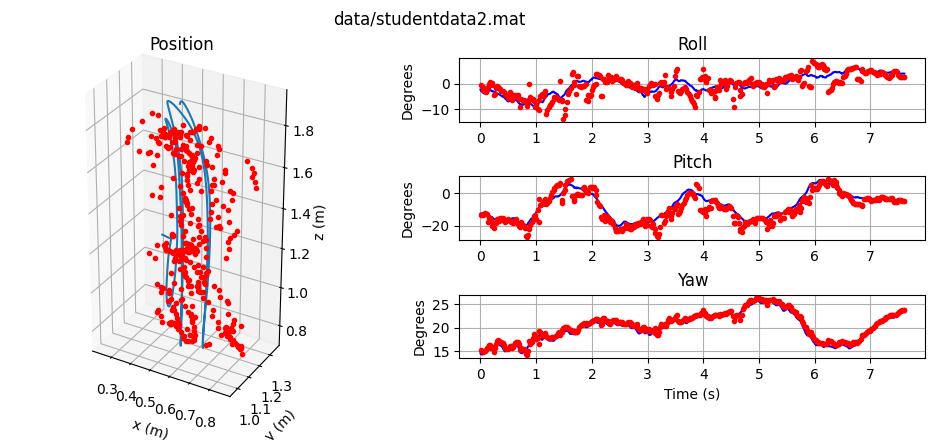

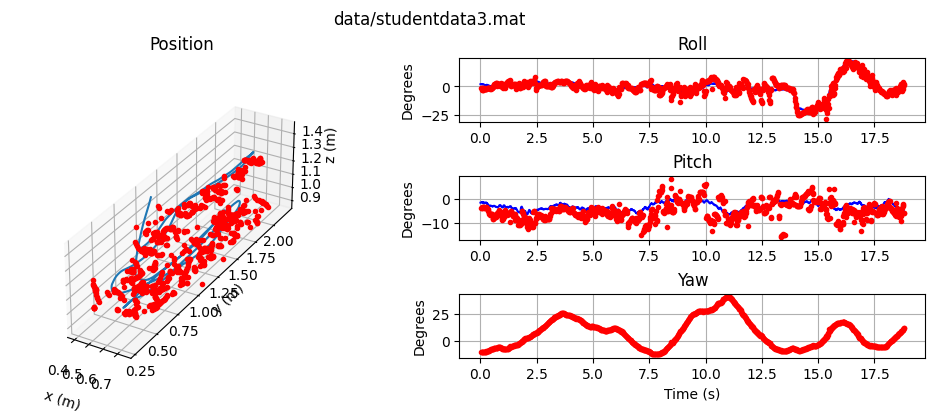

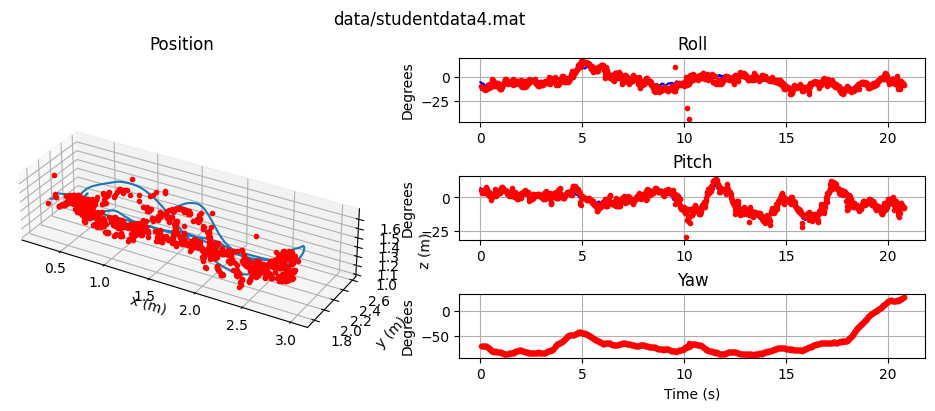

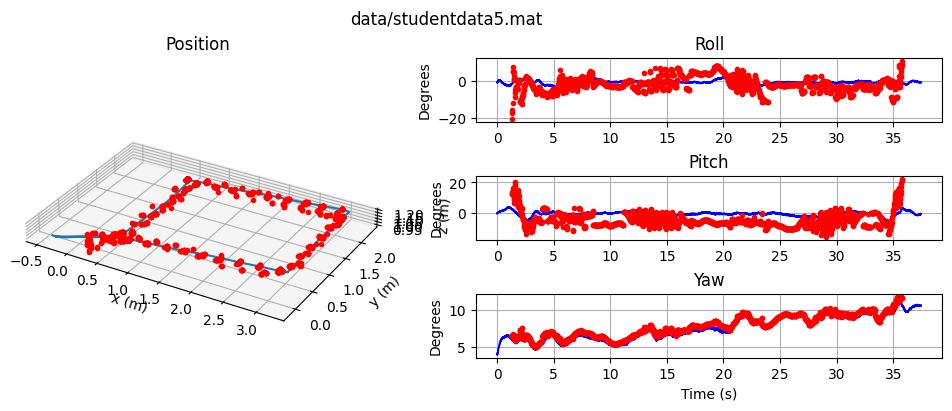

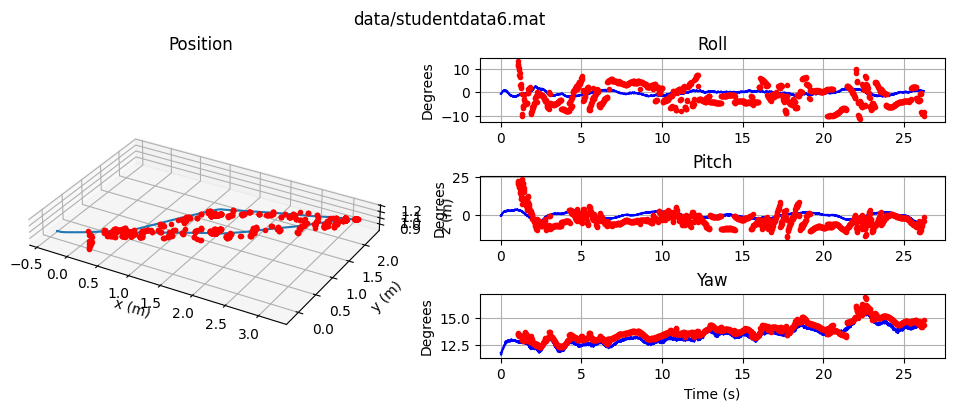

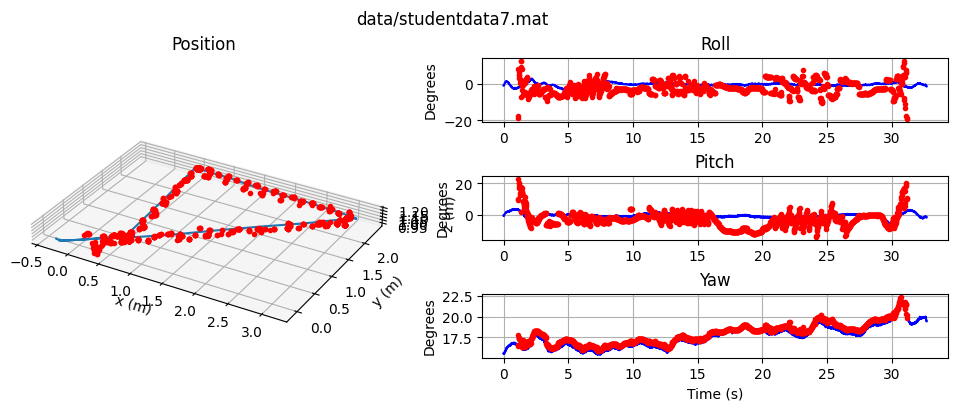

In [3]:
for i in range(8): # Loop through all datasets
    dataPath = f'data/studentdata{i}.mat'
    plot_task_2(dataPath) # Call plotting function
plt.show()

As evident in the plots above, my observation model is capable of giving a rough estimate of the drone's current position and rotation. However, this model is far from perfect. There is much noise in these measurements, an occasional constant bias for some states (e.g., data0 yaw), and some bad measurements due to strange camera behavior (e.g., data4 around 10s). In order to successfully use this observation model for accurate drone localization, a filter must be implemented.

## Taks 3: Covariance Estimation
To estimate the measurement covariance matrix (R) of our observation model, I will be calculating the sample covariance between observations and ground truth provided by the mocap with the following equation:

$R = \frac{1}{n-1}*\Sigma{v_tv_t^T}$

This is emplemented in the function `estimate_covariance`. An example is shown below.

In [4]:
R = estimate_covariance('data/studentdata0.mat')
print(R)

[[ 0.02711847 -0.00652164  0.00554712 -0.0042165  -0.01041416  0.01375965]
 [-0.00652164  0.00767815 -0.00216529 -0.00339575  0.00545123 -0.0044385 ]
 [ 0.00554712 -0.00216529  0.0020712  -0.00103347 -0.00386971  0.00352451]
 [-0.0042165  -0.00339575 -0.00103347  0.00566267  0.00202743 -0.00233212]
 [-0.01041416  0.00545123 -0.00386971  0.00202743  0.01482206 -0.00916339]
 [ 0.01375965 -0.0044385   0.00352451 -0.00233212 -0.00916339  0.00858448]]


My approach for obtaining a generalized R matrix usable in my filter:
1. Calculate the covariance matrix for all provided datasets.
2. Calculate the average of these 8 matricies.
3. Set covariances between different states to 0. (ie. only use variances)
4. Use a constant, average, variance value across x,y,z and roll,pitch,yaw states.

The process is completed below.

In [5]:
Rs = np.zeros([8,6,6])
for i in range(8):
    dataPath = f'data/studentdata{i}.mat'
    Ri = estimate_covariance(dataPath)
    Rs[i,:,:] = Ri

R = np.mean(Rs, axis=0) # Average covariance across 8 datasets
R = np.diag(np.diag(R)) # Ignore covariances between different states
R[0,0] = R[1,1] = R[2,2] = (R[0,0] + R[1,1] + R[2,2]) / 3.0 # Constant, average, x,y,x variance
R[3,3] = R[4,4] = R[5,5] = (R[3,3] + R[4,4] + R[5,5]) / 3.0 # Constant, average, roll, pitch, yaw variance

print(R)

[[0.00557645 0.         0.         0.         0.         0.        ]
 [0.         0.00557645 0.         0.         0.         0.        ]
 [0.         0.         0.00557645 0.         0.         0.        ]
 [0.         0.         0.         0.00412496 0.         0.        ]
 [0.         0.         0.         0.         0.00412496 0.        ]
 [0.         0.         0.         0.         0.         0.00412496]]


These results are showing a variance of 5.6 mm and 0.24 degrees, which are reasonable given the current application.

## Task 4: Nonlinear Kalman Filter (Unscented Kalman Filter)
My Unscented Kalman Filter is implemented as a function `UKF`, which given a dataset, R matrix and Q matrix, will return the filtered state at each time step. For the following examples, the R matrix from above will be used along with a process noise covariance matrix Q defined below.

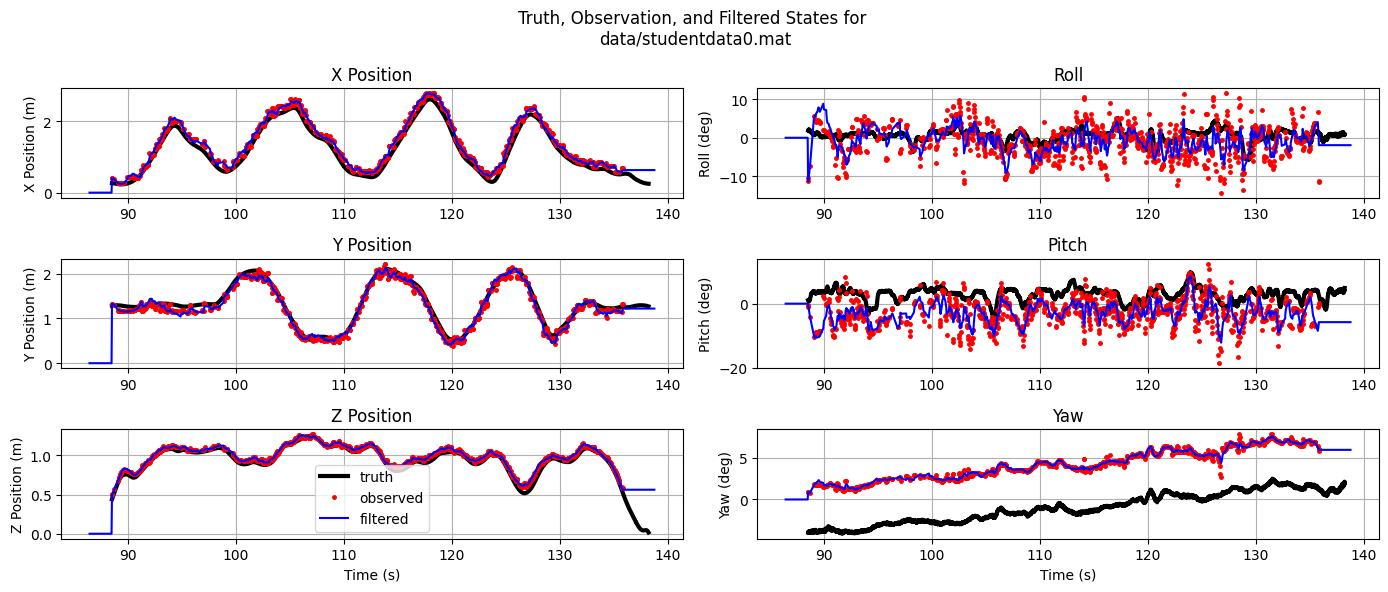

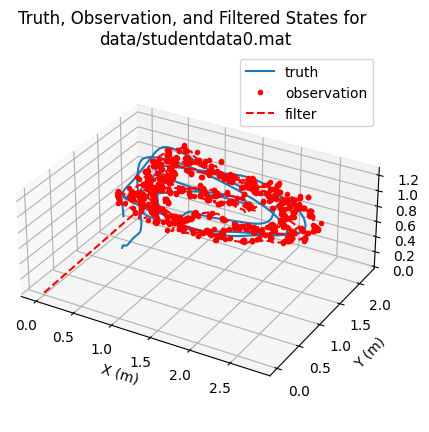

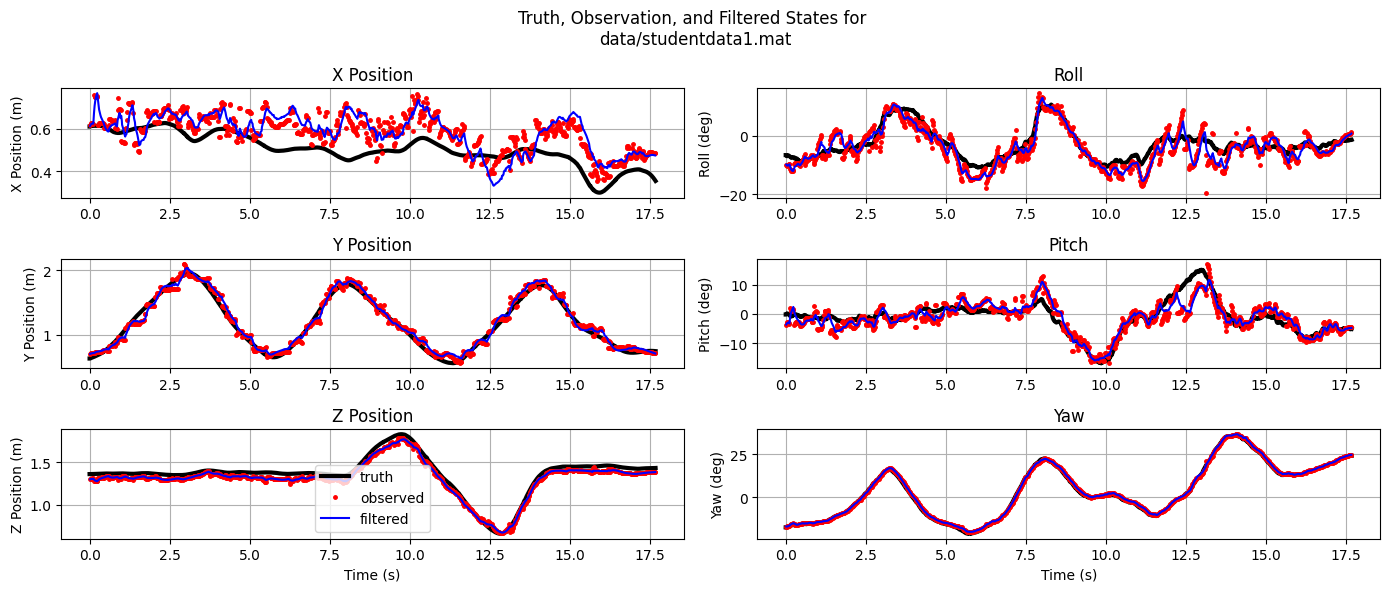

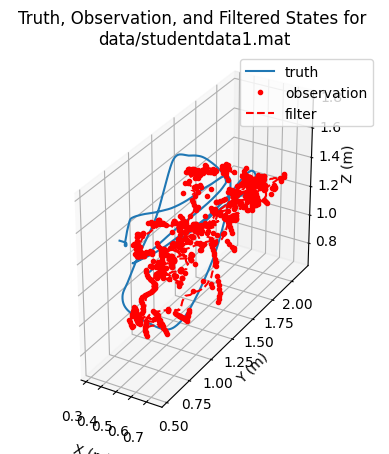

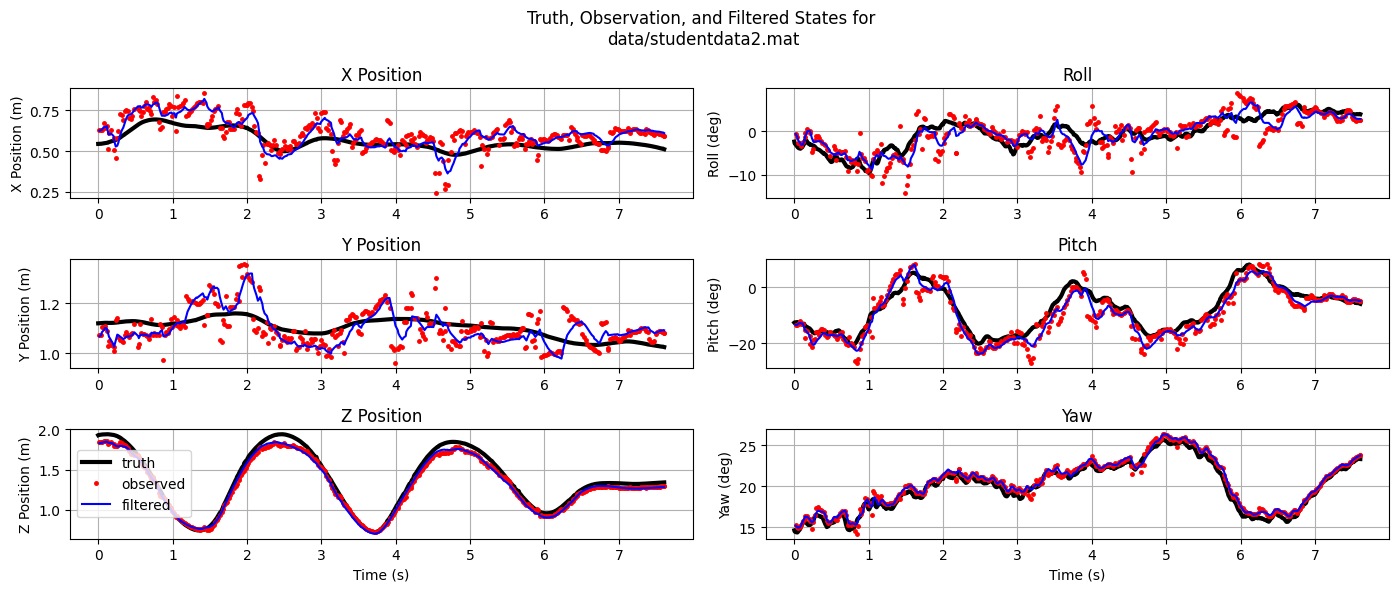

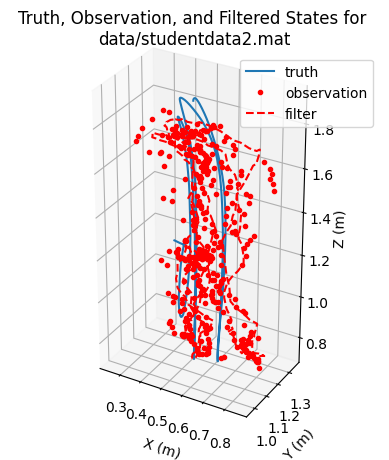

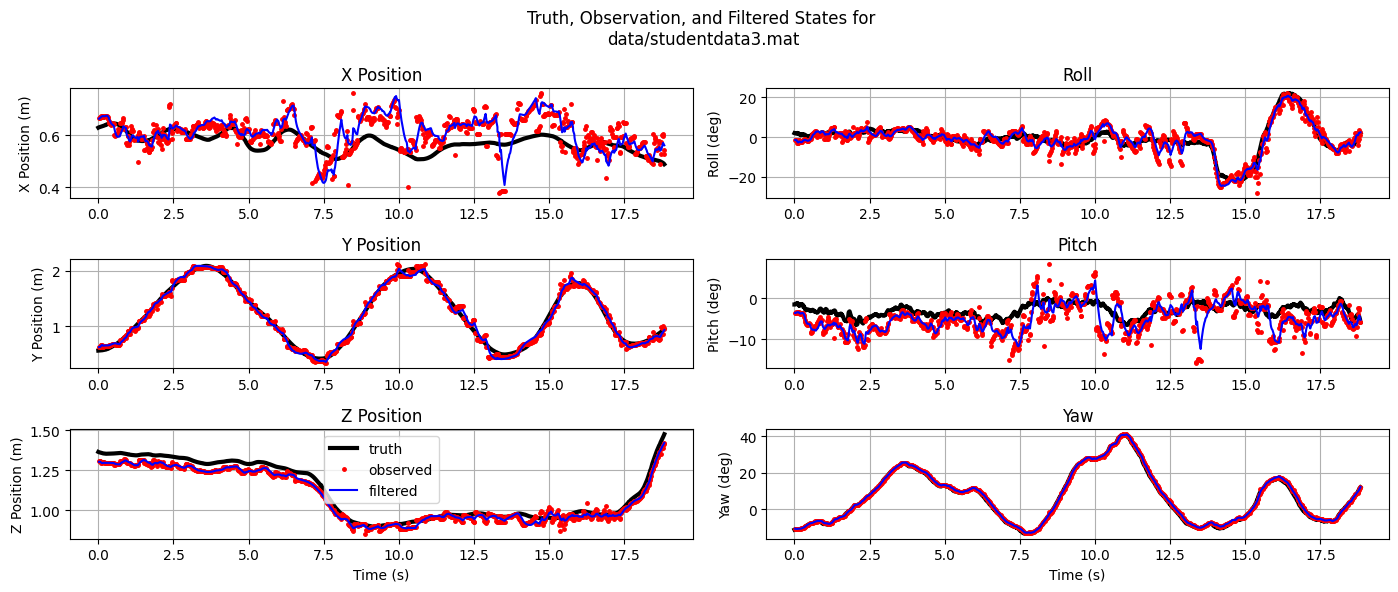

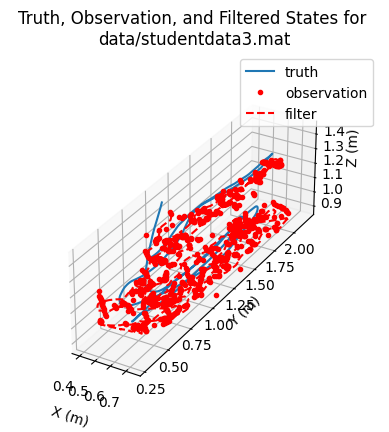

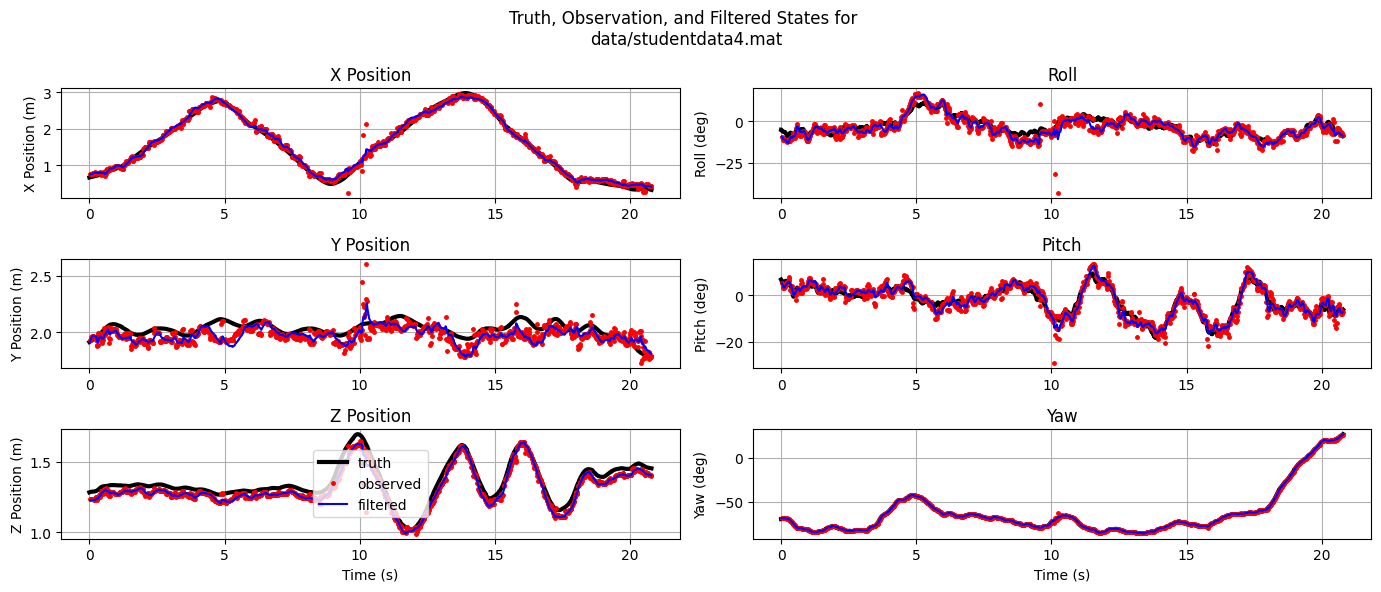

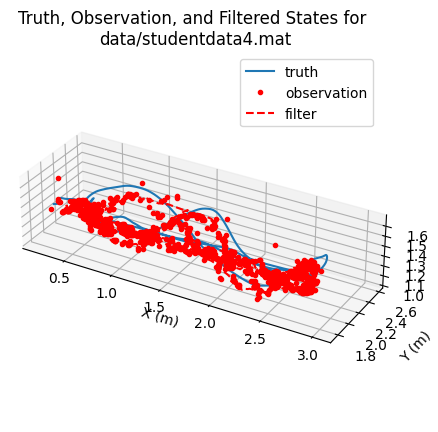

In [6]:
Q = np.eye(15) * 0.0001

for i in range(8): # Loop through all datasets
    dataPath = f'data/studentdata{i}.mat'
    xs, ts = UKF(dataPath, R, Q)
    plot_results2(xs, ts, dataPath) # Call plotting function
    plot_results3D(xs, ts, dataPath) # Call plotting function
    plt.show()

Implementing the UKF meaningfully improves our state estimation. Our filtered states effectively mitigate observation noise and largely disregard incorrect observations (e.g., data4 at 10s), enabling us to track states hidden from the observation model such as velocity, angular velocity, and gyroscope/accelerometer biases.

However, there is a limitation on our accuracy, largely stemming from the observation model. When the observation model introduces measurements with a constant bias, correcting these biases becomes challenging for the UKF. This issue is particularly evident in the yaw measurement from data0, and the roll/pitch measurements in data5-data7.

Overall, the UKF implementation enhances our capability for state estimation and localization on the drone.